In [1]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [3]:
linkwhite='https://drive.google.com/open?id=1XBIV3UcGD9huBlsotNAH2pTlwoajNx0Q'
fluff, id2 = linkwhite.split('=')
print (id2)

downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('credit_dataset.csv')  
dataframe = pd.read_csv('credit_dataset.csv', index_col=0)
dataframe.head()

1XBIV3UcGD9huBlsotNAH2pTlwoajNx0Q


ID GENDER CAR REALITY  ...  BEGIN_MONTH  AGE YEARS_EMPLOYED TARGET
0  5008806      M   Y       Y  ...           29   59              3      0
1  5008808      F   N       Y  ...            4   52              8      0
2  5008809      F   N       Y  ...           26   52              8      0
3  5008810      F   N       Y  ...           26   52              8      0
4  5008811      F   N       Y  ...           38   52              8      0

[5 rows x 19 columns]

In [4]:
# Change behaviour globaly
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# Copy
df = dataframe.copy()

In [6]:
# Shape dataframe
print('Rows    :', df.shape[0])
print('Columns :', df.shape[1])

Rows    : 25134
Columns : 19


In [7]:
# Preview NULL values
df.isna().sum()

ID                0
GENDER            0
CAR               0
REALITY           0
NO_OF_CHILD       0
INCOME            0
INCOME_TYPE       0
EDUCATION_TYPE    0
FAMILY_TYPE       0
HOUSE_TYPE        0
FLAG_MOBIL        0
WORK_PHONE        0
PHONE             0
E_MAIL            0
FAMILY SIZE       0
BEGIN_MONTH       0
AGE               0
YEARS_EMPLOYED    0
TARGET            0
dtype: int64

In [8]:
# Dtytes
df.dtypes

ID                  int64
GENDER             object
CAR                object
REALITY            object
NO_OF_CHILD         int64
INCOME            float64
INCOME_TYPE        object
EDUCATION_TYPE     object
FAMILY_TYPE        object
HOUSE_TYPE         object
FLAG_MOBIL          int64
WORK_PHONE          int64
PHONE               int64
E_MAIL              int64
FAMILY SIZE       float64
BEGIN_MONTH         int64
AGE                 int64
YEARS_EMPLOYED      int64
TARGET              int64
dtype: object

In [9]:
# Preview unique values
df.nunique()

ID                25134
GENDER                2
CAR                   2
REALITY               2
NO_OF_CHILD           9
INCOME              195
INCOME_TYPE           5
EDUCATION_TYPE        5
FAMILY_TYPE           5
HOUSE_TYPE            6
FLAG_MOBIL            1
WORK_PHONE            2
PHONE                 2
E_MAIL                2
FAMILY SIZE          10
BEGIN_MONTH          61
AGE                  47
YEARS_EMPLOYED       43
TARGET                2
dtype: int64

TARGET variable class distribution

0   0.983
1   0.017
Name: TARGET, dtype: float64


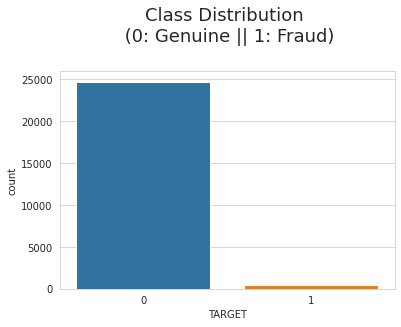

In [10]:
sns.countplot(df.TARGET).set_title('Class Distribution \n (0: Genuine || 1: Fraud)', size=18, pad=30)
print(df.TARGET.value_counts(normalize=True))
plt.show()

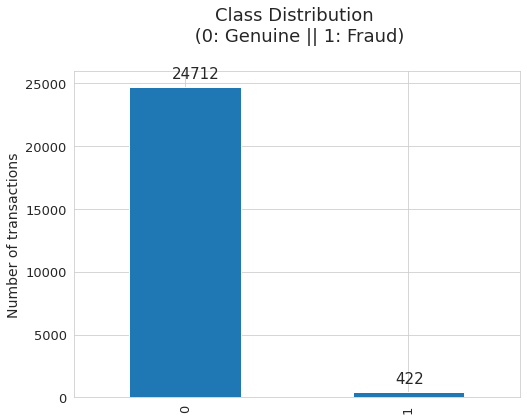

In [11]:
ax = df['TARGET'].value_counts().plot(kind='bar', figsize=(8,6), fontsize=13)
ax.set_title('Class Distribution \n (0: Genuine || 1: Fraud)', size=18, pad=30)
ax.set_ylabel('Number of transactions', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.19, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=15)

Data preparation

In [12]:
# Remap to integers
df['GENDER'] = [0 if x == 'M' else 1 for x in df['GENDER']]
df['CAR'] = [1 if x == 'Y' else 0 for x in df['CAR']]
df['REALITY'] = [1 if x == 'Y' else 0 for x in df['REALITY']]

# Create dummy variables
dummy_income_type = pd.get_dummies(df['INCOME_TYPE'], prefix='INC_TYPE', drop_first=True)
dummy_edu_type = pd.get_dummies(df['EDUCATION_TYPE'], prefix='EDU_TYPE', drop_first=True)
dummy_family_type = pd.get_dummies(df['FAMILY_TYPE'], prefix='FAM_TYPE', drop_first=True)
dummy_house_type = pd.get_dummies(df['HOUSE_TYPE'], prefix='HOUSE_TYPE', drop_first=True)

# Drop unnecessary columns
to_drop = ['ID', 'FLAG_MOBIL', 'INCOME_TYPE',
           'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE']
df.drop(to_drop, axis=1, inplace=True)

# Merge into a single dataframe
merged = pd.concat([df, dummy_income_type, dummy_edu_type, dummy_family_type, dummy_house_type], axis=1)
merged.head()

GENDER  CAR  ...  HOUSE_TYPE_Rented apartment  HOUSE_TYPE_With parents
0       0    1  ...                            0                        0
1       1    0  ...                            0                        0
2       1    0  ...                            0                        0
3       1    0  ...                            0                        0
4       1    0  ...                            0                        0

[5 rows x 30 columns]

In [13]:
from sklearn.preprocessing import MinMaxScaler
# # minmax: scales and translates each feature individually such that it is in the range of 0 to 1

# Scale only columns where value > 1
to_scale = [col for col in df.columns if df[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Replace original columns with scaled values
for col in scaled:
  merged[col] = scaled[col]

merged.head()

GENDER  CAR  ...  HOUSE_TYPE_Rented apartment  HOUSE_TYPE_With parents
0       0    1  ...                            0                        0
1       1    0  ...                            0                        0
2       1    0  ...                            0                        0
3       1    0  ...                            0                        0
4       1    0  ...                            0                        0

[5 rows x 30 columns]

### Pycaret

In [14]:
!pip install --upgrade pycaret

Requirement already up-to-date: pycaret in /usr/local/lib/python3.6/dist-packages (2.2.2)


In [15]:
import pycaret

In [16]:
from pycaret.classification import *

In [17]:
exp_clf = setup(
    data=merged, target='TARGET',
    session_id=123,
    remove_outliers=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.90,
    normalize=True,
    normalize_method='minmax',
    transformation=True,
    feature_selection=True,
    fix_imbalance=True,
    profile=True
    )

In [18]:
# Report the best models based on roc auc metric
top3_models = compare_models(n_select=3, sort='AUC', round=3)
print(top3_models)

Model  Accuracy   AUC  Recall  Prec.  \
rf               Random Forest Classifier     0.981 0.755   0.160  0.342   
et                 Extra Trees Classifier     0.978 0.722   0.178  0.254   
xgboost         Extreme Gradient Boosting     0.983 0.709   0.171  0.475   
catboost              CatBoost Classifier     0.982 0.705   0.163  0.408   
lightgbm  Light Gradient Boosting Machine     0.981 0.701   0.167  0.349   
knn                K Neighbors Classifier     0.911 0.673   0.379  0.072   
gbc          Gradient Boosting Classifier     0.947 0.657   0.134  0.051   
ada                  Ada Boost Classifier     0.862 0.613   0.220  0.027   
dt               Decision Tree Classifier     0.963 0.595   0.186  0.109   
lda          Linear Discriminant Analysis     0.689 0.583   0.432  0.022   
lr                    Logistic Regression     0.693 0.577   0.424  0.022   
nb                            Naive Bayes     0.299 0.549   0.740  0.017   
qda       Quadratic Discriminant Analysis     0.395 0.519   0.676  0.018   
svm                   SVM - Linear Kernel     0.670 0.000   0.473  0.023   
ridge                    Ridge Classifier     0.689 0.000   0.435  0.023   

            F1  Kappa   MCC  TT (Sec)  
rf       0.214  0.206 0.223     2.715  
et       0.207  0.196 0.200     2.142  
xgboost  0.243  0.236 0.271     4.016  
catboost 0.227  0.220 0.246    18.214  
lightgbm 0.222  0.214 0.231     0.570  
knn      0.121  0.097 0.135     1.472  
gbc      0.074  0.052 0.059     4.648  
ada      0.049  0.021 0.034     1.172  
dt       0.137  0.119 0.124     0.188  
lda      0.043  0.013 0.034     0.160  
lr       0.042  0.012 0.033     0.574  
nb       0.033  0.001 0.009     0.054  
qda      0.035  0.004 0.017     0.078  
svm      0.045  0.014 0.040     0.217  
ridge    0.043  0.013 0.035     0.055

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=

In [19]:
rf = create_model('rf', round=3)

Accuracy   AUC  Recall  Prec.    F1  Kappa   MCC
0        0.981 0.784   0.111  0.300 0.162  0.155 0.175
1        0.980 0.755   0.185  0.312 0.233  0.223 0.231
2        0.984 0.728   0.148  0.500 0.229  0.223 0.266
3        0.981 0.724   0.077  0.200 0.111  0.103 0.116
4        0.984 0.697   0.185  0.500 0.270  0.264 0.298
5        0.981 0.812   0.222  0.375 0.279  0.270 0.280
6        0.983 0.823   0.185  0.455 0.263  0.256 0.283
7        0.978 0.767   0.185  0.263 0.217  0.207 0.210
8        0.978 0.701   0.111  0.200 0.143  0.133 0.139
9        0.980 0.759   0.185  0.312 0.233  0.223 0.231
Mean     0.981 0.755   0.160  0.342 0.214  0.206 0.223
SD       0.002 0.041   0.043  0.107 0.054  0.054 0.060

In [20]:
# Tune model hyperparameter
tuned_rf = tune_model(rf, round=3, optimize='AUC')
print(tuned_rf)

Accuracy   AUC  Recall  Prec.    F1  Kappa   MCC
0        0.864 0.666   0.222  0.028 0.050  0.022 0.037
1        0.868 0.706   0.296  0.038 0.068  0.040 0.066
2        0.877 0.686   0.185  0.026 0.046  0.019 0.029
3        0.890 0.632   0.192  0.030 0.052  0.025 0.038
4        0.861 0.643   0.407  0.048 0.087  0.059 0.102
5        0.856 0.717   0.444  0.050 0.091  0.063 0.111
6        0.882 0.664   0.333  0.048 0.084  0.057 0.090
7        0.852 0.625   0.333  0.038 0.068  0.040 0.070
8        0.853 0.560   0.222  0.026 0.047  0.018 0.031
9        0.868 0.684   0.370  0.047 0.083  0.056 0.093
Mean     0.867 0.658   0.301  0.038 0.067  0.040 0.067
SD       0.012 0.044   0.087  0.009 0.017  0.017 0.030

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


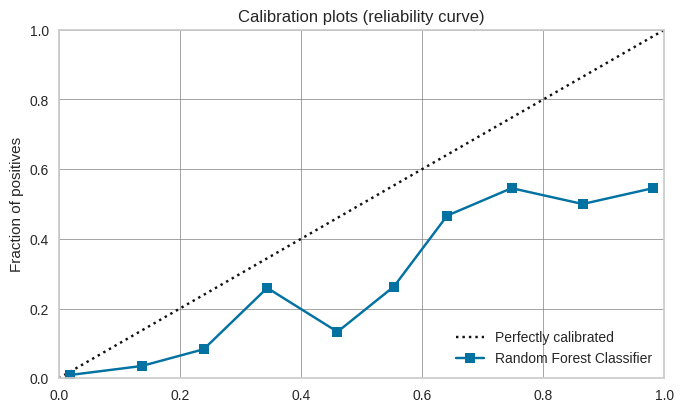

In [21]:
plot_model(rf, plot='calibration')

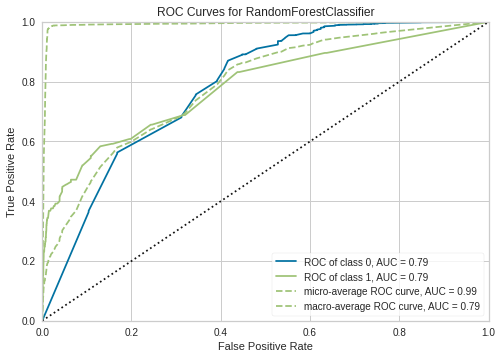

In [22]:
plot_model(rf, plot='auc')

In [23]:
evaluate_model(rf)

Parameters
bootstrap                      True
ccp_alpha                       0.0
class_weight                   None
criterion                      gini
max_depth                      None
max_features                   auto
max_leaf_nodes                 None
max_samples                    None
min_impurity_decrease           0.0
min_impurity_split             None
min_samples_leaf                  1
min_samples_split                 2
min_weight_fraction_leaf        0.0
n_estimators                    100
n_jobs                           -1
oob_score                     False
random_state                    123
verbose                           0
warm_start                    False

In [24]:
!pip install shap

     |████████████████████████████████| 327kB 12.4MB/s 
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463899 sha256=996c90b74267c0bfe3a57a983891a7398f585a44c353e283b5212a924c8ae73d
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built shap


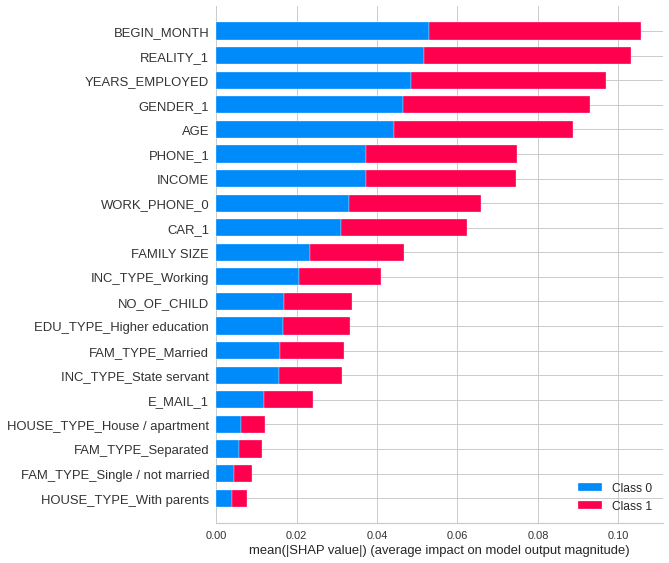

In [25]:
interpret_model(rf)

In [26]:
predict_model(rf)

Model  Accuracy   AUC  Recall  Prec.    F1  Kappa   MCC
0  Random Forest Classifier     0.983 0.785   0.248  0.449 0.320  0.311 0.326

EDU_TYPE_Higher education  INC_TYPE_State servant  ...  Label  Score
0                             0                       0  ...      0  1.000
1                             1                       0  ...      0  1.000
2                             1                       1  ...      0  0.860
3                             0                       0  ...      0  1.000
4                             1                       1  ...      0  0.960
...                         ...                     ...  ...    ...    ...
7536                          1                       0  ...      0  0.980
7537                          0                       0  ...      0  0.780
7538                          1                       0  ...      0  1.000
7539                          0                       0  ...      0  1.000
7540                          0                       0  ...      0  0.950

[7541 rows x 27 columns]